## Comparing baseline model fits

In [1]:
import numpy as np
import scipy.stats as stats
import nibabel.freesurfer.mghformat as mgh
import h5py

import sys

sys.path.append("..")

from paths import *
from constants import *

sys.path.append(CODE_PATH)

from utils.general_utils import make_iterable

In [2]:
CODE_PATH

'/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/code/fit_pipeline/'

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors as mcolors

In [4]:
import os 
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [5]:
def reject_outliers(data, m=2.):
    d = np.abs(data - np.mean(data))
    mdev = np.mean(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

In [26]:
subjid = ["01", "02", "03", "04", "05", "06", "07", "08"]
roi = "streams_shrink10"
hemi = "lh"
mapping_func = "Ridge" #"PLS"
CV = 1 #0
subsample = 2
ROI_NAMES = ['Early',
             'Midventral',
             'Midlateral',
             'Midparietal',
             'Ventral',
             'Lateral',
             'Parietal']
models = [ "untrained_alexnet", "alexnet_torch", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101"] #, "slowfast_full1"]

In [27]:
means_nc = np.empty((len(subjid), len(ROI_NAMES)))
all_nc = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

means = np.empty((len(subjid), len(ROI_NAMES), len(models)))
all_rs = [[[[] for m in range(len(models))] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

for sidx, sid in enumerate(subjid):
    
    # Get ROI data
    mgh_file = mgh.load(
        NSDDATA_PATH
        + "freesurfer/subj"
        + sid
        + "/label/"
        + hemi
        + "."
        + roi
        + ".mgz"
    )
    streams = mgh_file.get_fdata()[:, 0, 0]
    streams_trim = streams[streams != 0]
    num_vox = streams_trim.shape[0]
    
    # Get noise ceiling estimates
    mgh_file = mgh.load(
        stem
        + "/data/nsddata_betas/ppdata/subj"
        + sid
        + "/nativesurface/betas_fithrf_GLMdenoise_RR/"
        + hemi
        + ".nc_3trials.mgh"
    )
    NC = mgh_file.get_fdata()[:, 0, 0]
    NC_trim = NC[streams != 0]
    for r in range(len(ROI_NAMES)):
        all_nc[sidx][r] = NC_trim[streams_trim==r+1]/100
        means_nc[sidx, r] = np.mean(NC_trim[streams_trim==r+1]/100)
    
    for midx, model_name in enumerate(models):
        
        if model_name == "untrained_alexnet":
            model_name = "alexnet_torch"
            pretrained = False
        else:
            pretrained = True
            
        # get model fits
        load_path = (RESULTS_PATH
                    + "fits/"
                    +("by_layer_" if model_name == "slowfast_full1" else "")
                    +"subj"
                    + sid
                    + "_"
                    + hemi
                    + "_"
                    + roi
                    + "_"
                    + model_name
                    + "_"
                    + mapping_func
                    + "_subsample_"
                    + str(subsample)
                    + "_"
                    + str(CV)
                    + "CV_"
                    + ("0pretraining_" if pretrained is False else "1pretraining_") # else ""
                    + ("1pretraining_" if model_name == "slowfast_full1" else "")
                    + "fits"
                    + ".hdf5")
        fits = {}
        with h5py.File(load_path, "r") as f:
            keys = f.keys()
            for k in keys:
                fits[k] = f[k][:]
        
        if model_name == "alexnet":
            layer_keys = ALEXNET_LAYERS
        elif model_name == "alexnet_torch":
            layer_keys = ALEXNET_TORCH_LAYERS
        elif model_name == "vgg16":
            layer_keys = VGG16_LAYERS
        elif model_name == "resnet18":
            layer_keys = RESNET18_LAYERS
        elif model_name == "resnet50":
            layer_keys = RESNET50_LAYERS
        elif model_name == "resnet101":
            layer_keys = RESNET101_LAYERS
        elif model_name == "cornet-s":
            layer_keys = CORNETS_LAYERS
        elif model_name == "slowfast_full1":
                layer_keys = MATCHING_SLOWFAST_LAYERS
        layer_keys = [
            item
            for sublist in [
                [item] if type(item) is not list else item for item in layer_keys
            ]
            for item in sublist
        ]
        
        rs_by_layer = np.zeros((len(layer_keys), num_vox))
        for lix, layer in enumerate(layer_keys):
            rs_by_layer[lix,:] = fits[layer] #reshape dict to array
        max_rs = np.amax(rs_by_layer, axis=0)
            
        for r in range(len(ROI_NAMES)):
            all_rs[sidx][r][midx] = max_rs[streams_trim==r+1]
            means[sidx, r, midx] =  np.mean(max_rs[streams_trim==r+1])
    

OSError: Unable to open file (unable to open file: name = '/oak/stanford/groups/kalanit/biac2/kgs/projects/Dawn/NSD/results/fits/subj01_lh_streams_shrink10_resnet101_Ridge_subsample_2_1CV_1pretraining_fits.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

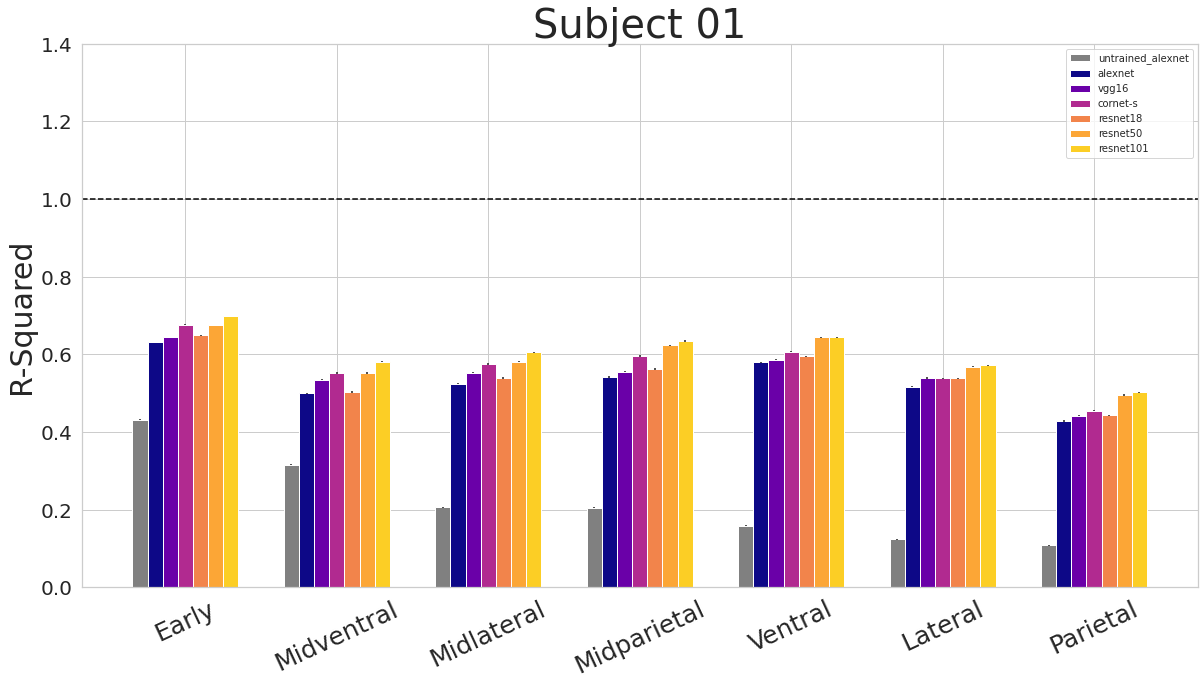

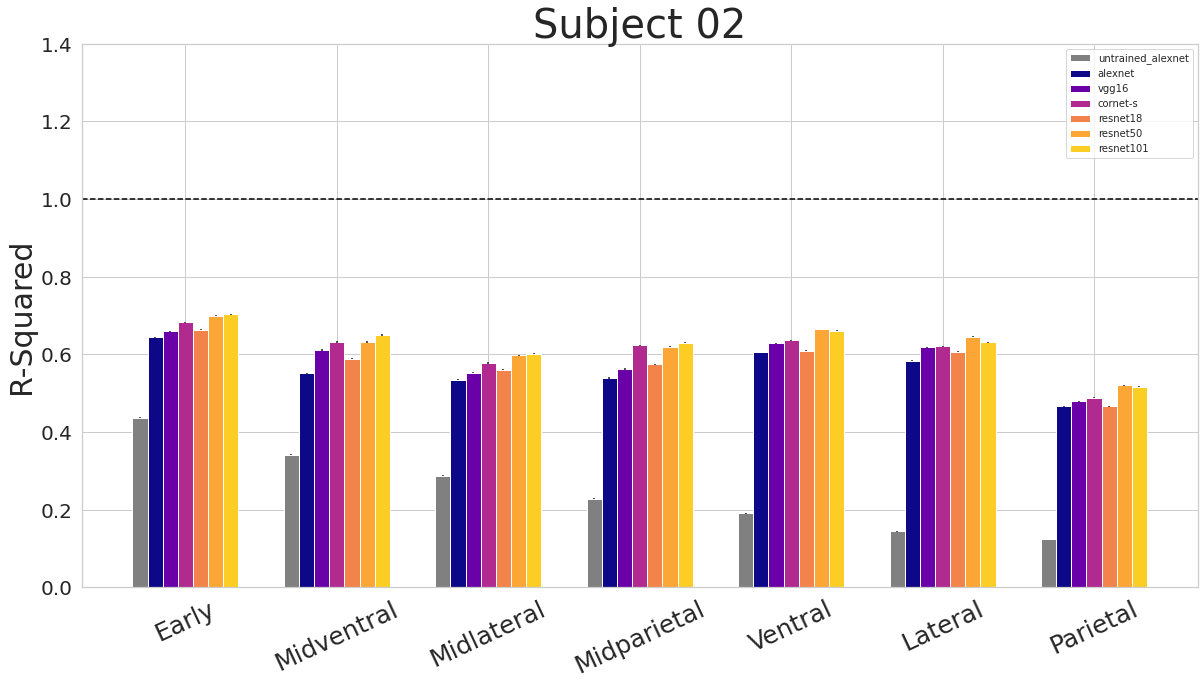

<ipython-input-19-36b40cf83ba0>:22: RuntimeWarning: divide by zero encountered in true_divide
  corrected_medians[sidx][r][midx] = np.median(reject_outliers(all_rs[sidx][r][midx]/all_nc[sidx][r]))
<ipython-input-5-a349c430b6f4>:2: RuntimeWarning: invalid value encountered in subtract
  d = np.abs(data - np.mean(data))
/share/kalanit/users/dfinzi/fit_venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/share/kalanit/users/dfinzi/fit_venv/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-19-36b40cf83ba0>:24: RuntimeWarning: divide by zero encountered in true_divide
  data = [np.median(reject_outliers(all_rs[sidx][r][midx]/all_nc[sidx][r])) for r in range(len(ROI_NAMES))]
<ipython-input-19-36b40cf83ba0>:25: RuntimeWarning: divide by zero encountered in true_divide
  error =

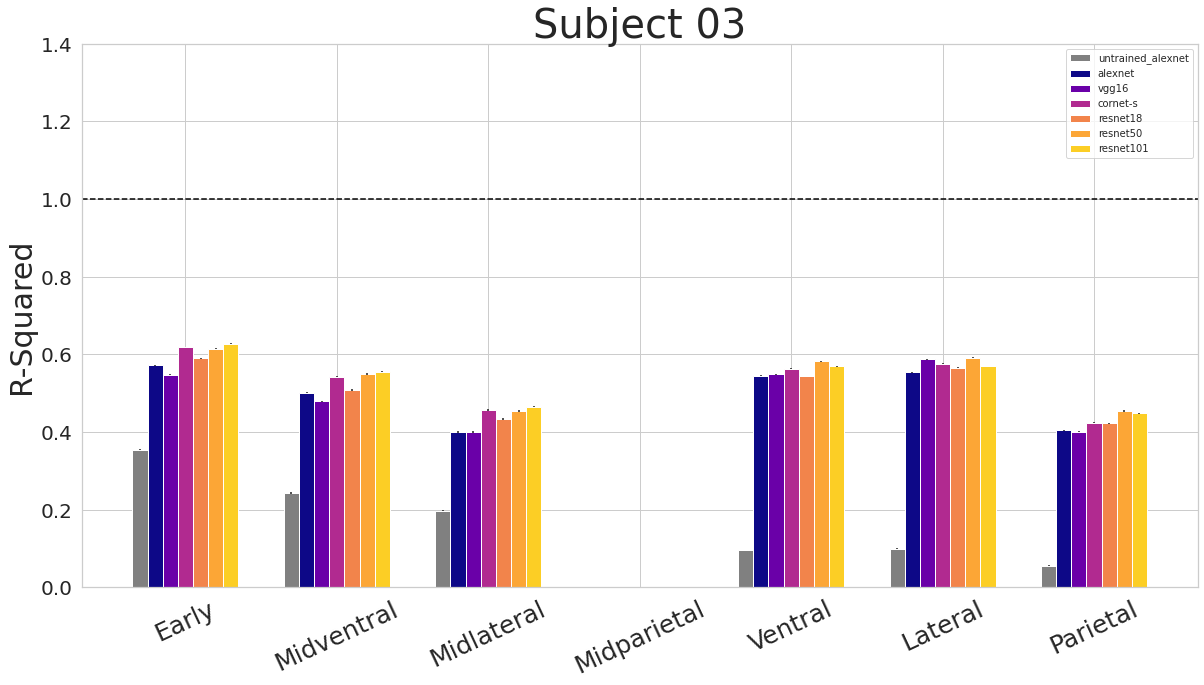

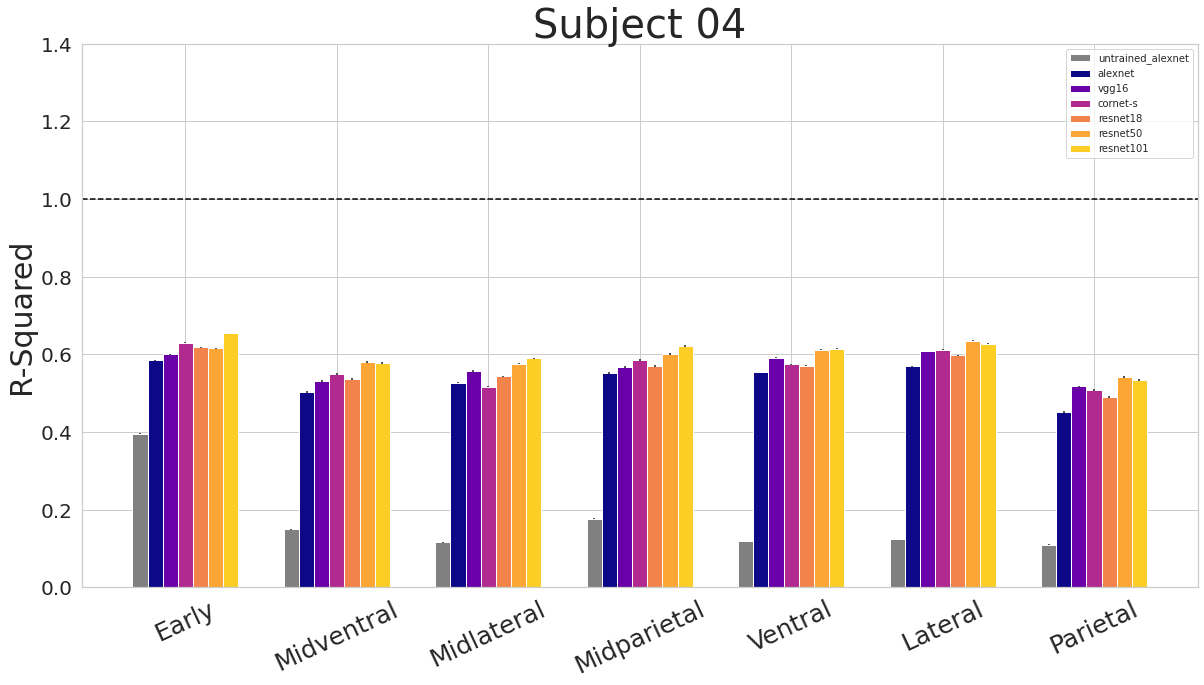

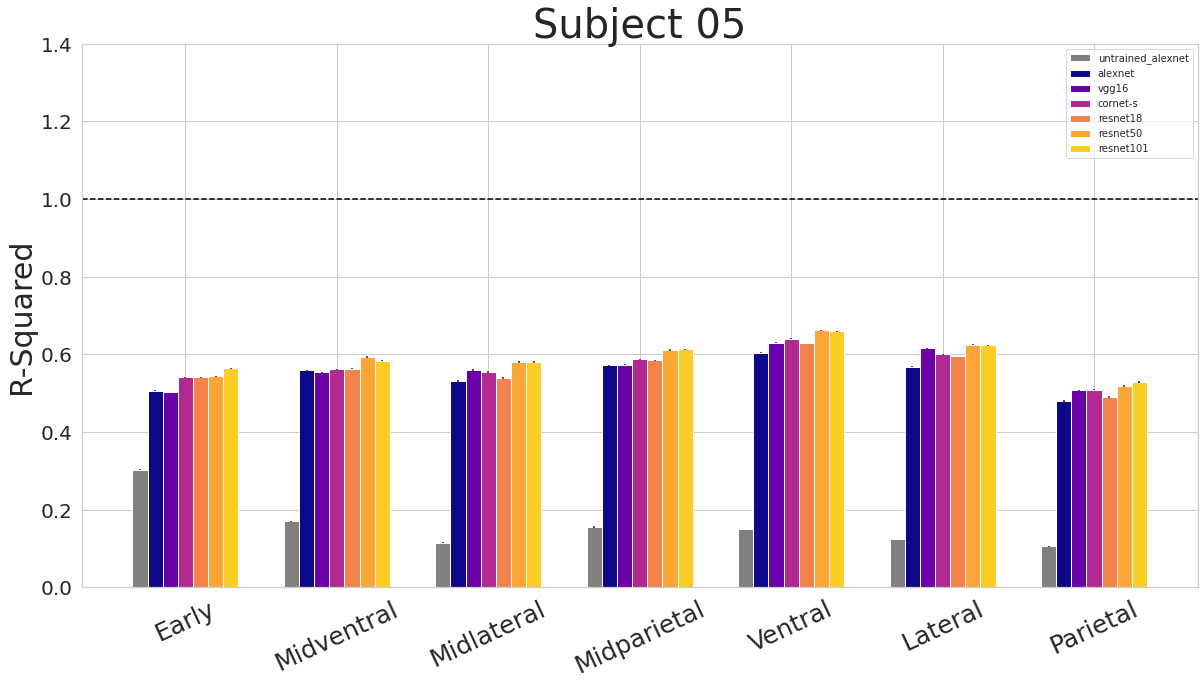

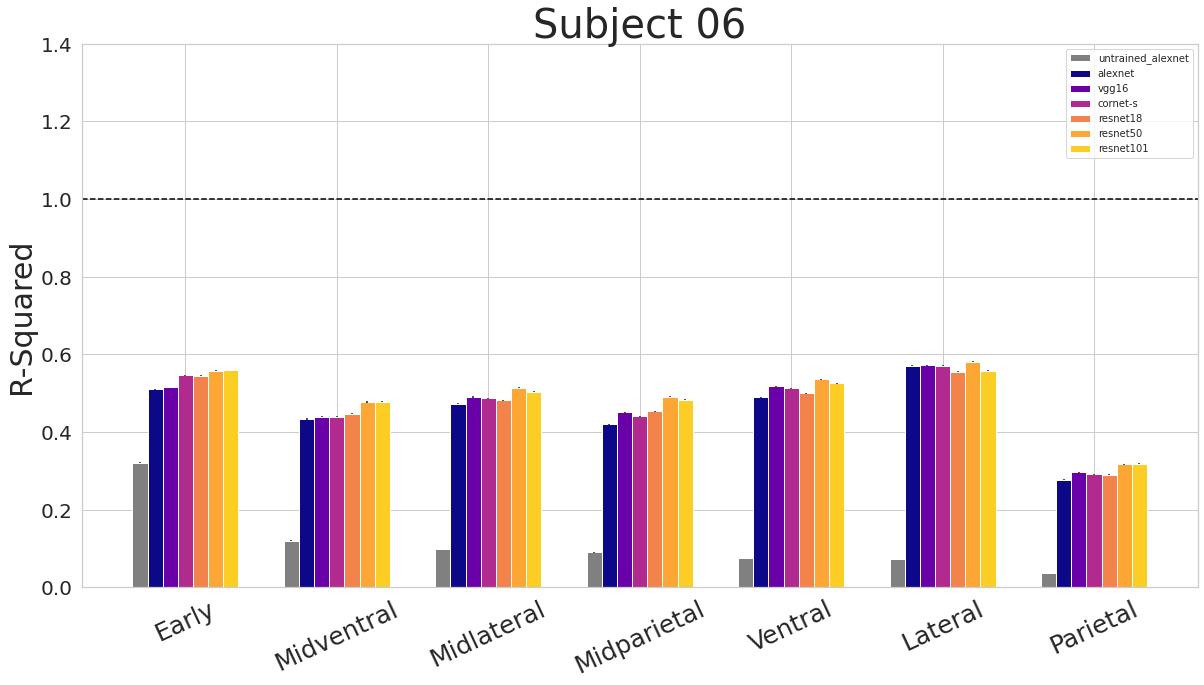

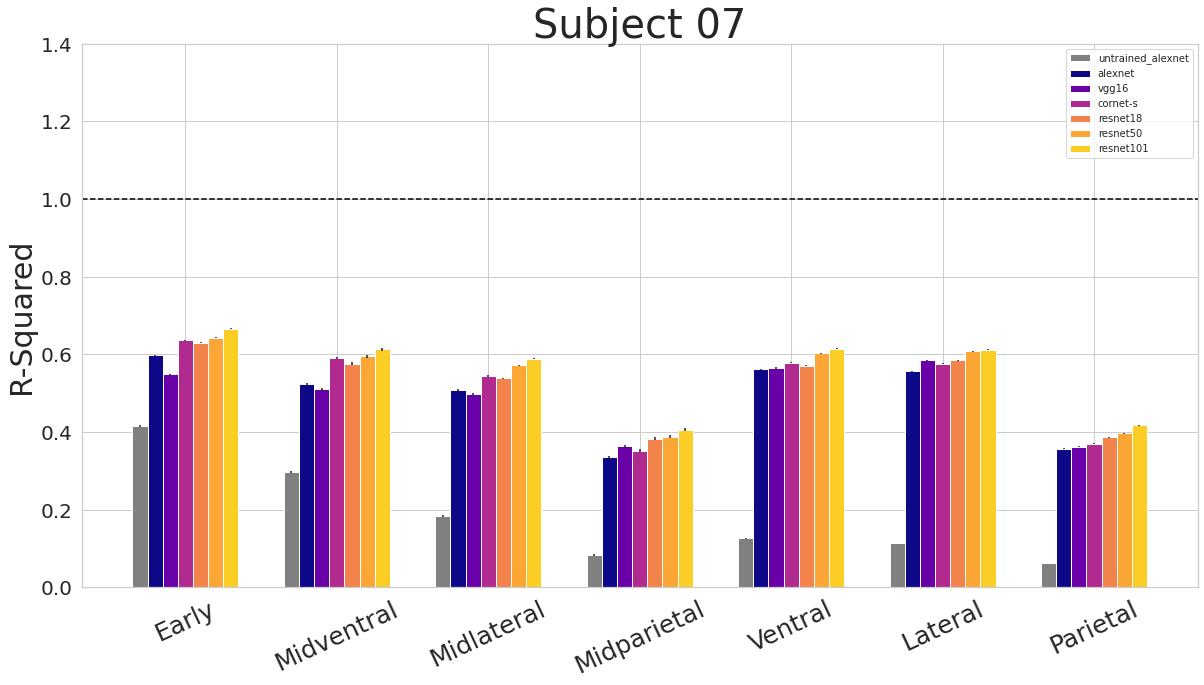

/share/kalanit/users/dfinzi/fit_venv/lib/python3.8/site-packages/numpy/core/_methods.py:160: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


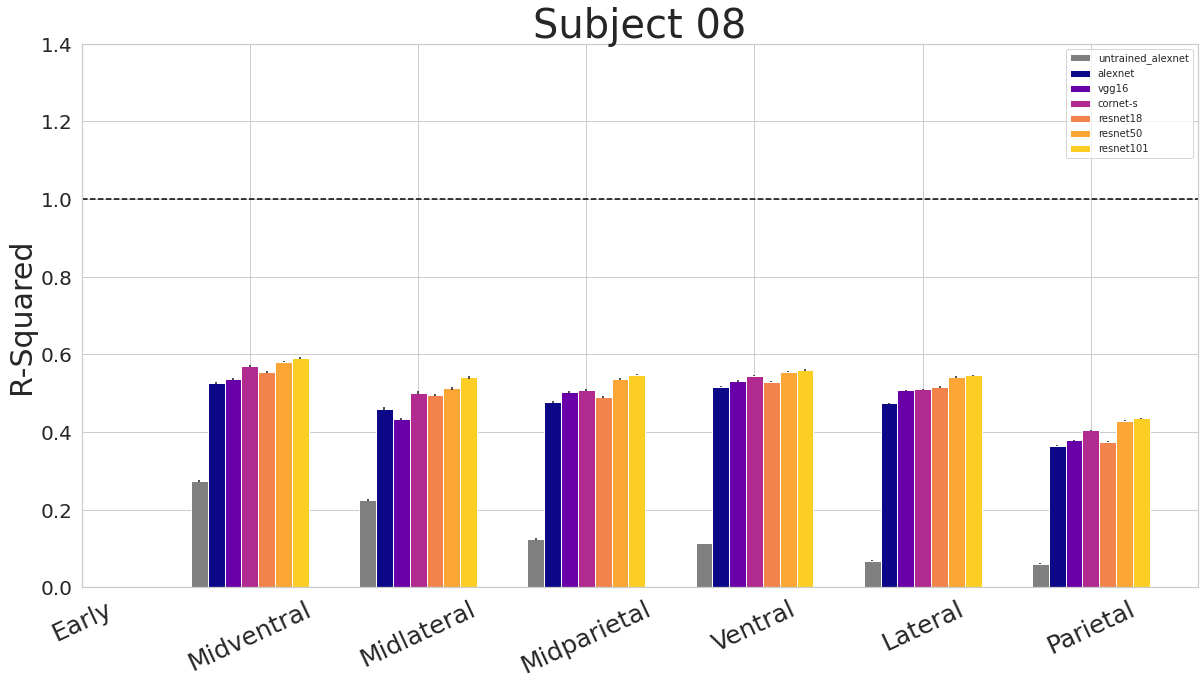

In [19]:
corrected_medians = np.empty((len(subjid), len(ROI_NAMES), len(models)))

cmap = matplotlib.cm.get_cmap('plasma')
rgba = np.zeros((len(models), 4))
color_range = [0, 0, .2, .4, .7, .8, .9, .99]
for midx, model_name in enumerate(models):
    if model_name == "untrained_alexnet":
        rgba[midx,:] = [128/255, 128/255, 128/255, 1]
    else:
        rgba[midx,:] = cmap(color_range[midx])
        
for sidx, sid in enumerate(subjid):
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('white')
    
    # set width of bars
    barWidth = 0.1
    
    for midx, model_name in enumerate(models):
        
        for r in range(len(ROI_NAMES)):
            corrected_medians[sidx][r][midx] = np.median(reject_outliers(all_rs[sidx][r][midx]/all_nc[sidx][r]))
                        
        data = [np.median(reject_outliers(all_rs[sidx][r][midx]/all_nc[sidx][r])) for r in range(len(ROI_NAMES))]
        error = [stats.sem(reject_outliers(all_rs[sidx][r][midx]/all_nc[sidx][r])) for r in range(len(ROI_NAMES))]

        # Set position of bar on X axis
        if midx == 0:
            base = np.arange(len(data))
            r = [x - (barWidth)*(len(models)/2) for x in base]
        else:
            r = [x + barWidth for x in prev_r]

        # Make the plot
        if model_name == "alexnet_torch":
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label="alexnet")
        else:
            plt.bar(r, data, yerr=error, width=barWidth, edgecolor='white', color = rgba[midx], label=model_name)
        
        prev_r = r
        
    plt.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')
    plt.xticks([r - barWidth/2 for r in range(len(data))], ROI_NAMES, rotation=25, fontsize=25);

    plt.ylabel('R-Squared',size = 30)
    plt.yticks(fontsize=20)
    
    plt.ylim([0, 1.4])

    title_string = "Subject "
    title_string += sid
    plt.title(title_string,size = 40)

    # Create legend & Show graphic
    plt.legend(fontsize=10)

    save_path = (RESULTS_PATH 
                + "fits/figures/subj"
                + sid
                + "_"
                + hemi
                + "_"
                + roi
                + "_"
                + mapping_func
                + "_"
                + str(CV)
                + "_PCA_fitcomp_bymodel_norm_by_trad_nc.png")

    #fig.savefig(save_path)
    plt.show()



### Experimenting with pandas and seaborn

In [20]:
d = {
    'subject_name': np.concatenate((np.tile('subj01',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj02',len(ROI_NAMES)*len(models)), 
                                    np.tile('subj03',len(ROI_NAMES)*len(models)),
                                    np.tile('subj04',len(ROI_NAMES)*len(models)),
                                    np.tile('subj05',len(ROI_NAMES)*len(models)),
                                    np.tile('subj06',len(ROI_NAMES)*len(models)),
                                    np.tile('subj07',len(ROI_NAMES)*len(models)),
                                    np.tile('subj08',len(ROI_NAMES)*len(models)))),
    'roi': np.tile(ROI_NAMES, len(subjid)*len(models)),
    'Model': np.ravel(np.tile(np.ravel([np.tile(m, len(ROI_NAMES)) for m in models]), len(subjid))),
    'corrected': np.swapaxes(corrected_medians,1,2).ravel(),
    'nc': np.ravel(np.tile(means_nc,len(models)))
    
}

In [21]:
print(len(d['subject_name']))
print(len(d['roi']))
print(len(d['Model']))
print(len(d['corrected']))
print(len(d['nc']))

392
392
392
392
392


In [22]:
df = pd.DataFrame(d,columns=['subject_name','roi','Model', 'corrected', 'nc'])
df  

,subject_name,roi,Model,corrected,nc
0,subj01,Early,untrained_alexnet,0.431392,0.540384
1,subj01,Midventral,untrained_alexnet,0.315856,0.488188
2,subj01,Midlateral,untrained_alexnet,0.205355,0.427014
3,subj01,Midparietal,untrained_alexnet,0.205238,0.425549
4,subj01,Ventral,untrained_alexnet,0.158612,0.433113
...,...,...,...,...,...
387,subj08,Midlateral,resnet101,0.540430,0.271028
388,subj08,Midparietal,resnet101,0.547849,0.345459
389,subj08,Ventral,resnet101,0.559353,0.383733
390,subj08,Lateral,resnet101,0.545775,0.352622


In [23]:
# Wanted palette details
roi_palette = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']
color_codes_wanted = ROI_NAMES
#cdict = dict(zip(color_codes_wanted, [mcolors.to_rgba(c) for c in roi_palette]))
cdict = dict(zip(models, rgba))
#
mcolors.get_named_colors_mapping().update(cdict)
#
model_colors=np.ravel([np.tile(m, len(ROI_NAMES)) for m in models])

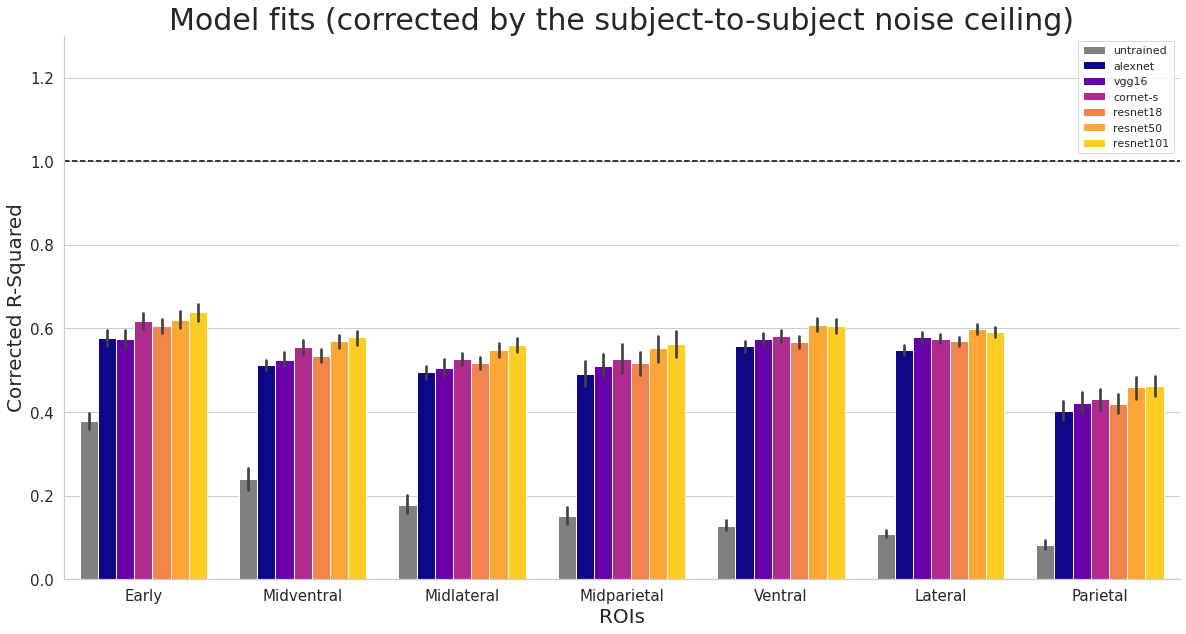

In [25]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x="roi", y="corrected", hue="Model",palette='cool_r',data=df, ci=68, ax=ax)

for idx, bar in enumerate(ax.patches):
    bar.set_color(model_colors[idx])
    bar.set_edgecolor("w")
    
# iterate over range of number of rows    
ax.set_xlabel('ROIs', fontsize=20)
ax.set_ylabel('Corrected R-Squared', fontsize=20)
ax.tick_params(labelsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

h, l = ax.get_legend_handles_labels()
model_labels = [ "untrained", "alexnet", "vgg16", "cornet-s", "resnet18", "resnet50", "resnet101", "slowfast"]
ax.legend(h, model_labels)

plt.title('Model fits (corrected by the subject-to-subject noise ceiling)',size = 30)
plt.ylim([0, 1.3])

ax.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')

save_path = (RESULTS_PATH 
                + "fits/figures/groupavg_"
                + hemi
                + "_"
                + roi
                + "_"
                + mapping_func
                + "_"
                + str(CV)
                + "CV_PCA_fitcomp_bymodel_norm_by_trad_nc.png")

fig.savefig(save_path)
